In [1]:
import numpy as np 
import pandas as pd 
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from unet import UNet
import time
import cv2
%matplotlib inline
dsb_data_dir = os.path.join('.', 'data')
stage_label = 'data/stage1'

In [2]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('/')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('/')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[0])
img_df.sample(3)

,path,ImageId,ImageType,TrainingSplit,Stage
5724,./data/stage1_train/49edc2f7715100fb0390916e52...,49edc2f7715100fb0390916e52b3fd11a921f02e59509d...,masks,train,stage1
28644,./data/stage1_train/08275a5b1c2dfcd739e8c4888a...,08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185...,masks,train,stage1
19197,./data/stage1_train/3a22fe593d9606d4f137461dd6...,3a22fe593d9606d4f137461dd6802fd3918f9fbf36f4a6...,masks,train,stage1


In [3]:
# np.stack to squash multidim-list to ndarray
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    img = [imread(c_img) for c_img in in_img_list]
    img_stack = np.stack(img, 0)
    img_sum = np.sum(img_stack, 0)
#     return img_sum/255.0
    return img_sum

GRID_SIZE = 8
def rgb_clahe(in_rgb_img): 
    bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(GRID_SIZE,GRID_SIZE))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr[:,:,[2,1,0]]

def rgb_clahe_justl(in_rgb_img): 
    in_rgb_img = in_rgb_img.astype(np.uint8)
    bgr = in_rgb_img[:,:,[2,1,0]] # flip r and b
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(GRID_SIZE,GRID_SIZE))
    return clahe.apply(lab[:,:,0])

def img_invert(in_img):
    return (255-in_img) if in_img.mean()>127 else in_img

In [4]:
#train data
train_df = img_df[img_df.TrainingSplit == 'train']
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows[n_rows.ImageType == 'masks']['path'].values.tolist()
    c_row['images'] = n_rows[n_rows.ImageType == 'images']['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS].astype(np.uint8))
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(np.uint8))
train_img_df['normalized_images'] = train_img_df['images'].map(lambda x: rgb_clahe_justl(x)).map(lambda x: img_invert(x).astype(np.uint8))                                                                                             
train_img_df.head(3)                                                                                             
# train_img_df.sample(3)

,ImageId,Stage,images,masks,normalized_images
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,stage1,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [5, 5, 5], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7,..."
1,003cee89357d9fe13516167fd67b609a164651b2193458...,stage1,"[[[5, 5, 5], [5, 5, 5], [5, 5, 5], [4, 4, 4], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[9, 9, 9, 6, 13, 9, 13, 6, 9, 9, 6, 6, 9, 6, ..."
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,stage1,"[[[130, 62, 165], [126, 56, 162], [121, 55, 16...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[164, 170, 173, 173, 174, 178, 177, 170, 159,..."


In [5]:
#test data
test_df = img_df[img_df.TrainingSplit == 'test']
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows[n_rows.ImageType == 'images']['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS].astype(np.uint8))
test_img_df['normalized_images'] = test_img_df['images'].map(lambda x: rgb_clahe_justl(x)).map(lambda x: img_invert(x).astype(np.uint8))                                                                                             
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(3)

65 images to process


,ImageId,Stage,images,normalized_images
44,9f17aea854db13015d19b34cb2022cfdeda44133323fcd...,stage1,"[[[234, 227, 207], [230, 226, 194], [229, 226,...","[[50, 56, 56, 53, 42, 37, 48, 56, 48, 37, 29, ..."
9,191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107...,stage1,"[[[4, 4, 4], [3, 3, 3], [3, 3, 3], [4, 4, 4], ...","[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4,..."
57,dab46d798d29aff2e99c23f47ed3064f5cafb1644629b0...,stage1,"[[[4, 4, 4], [4, 4, 4], [3, 3, 3], [3, 3, 3], ...","[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,..."


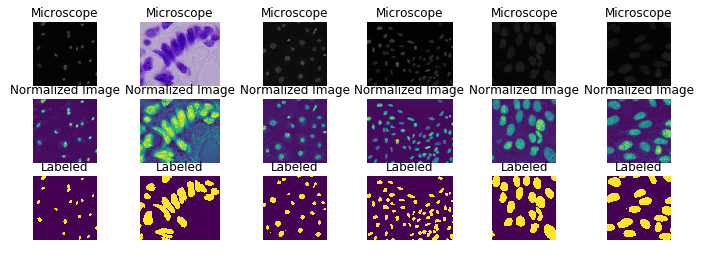

In [6]:
n_img = 6
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_norm, c_lab) in zip(train_img_df.sample(n_img).iterrows(), m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_norm.imshow(c_row['normalized_images'])
    c_norm.axis('off')
    c_norm.set_title('Normalized Image')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [7]:
train = train_img_df.sample(frac=0.9)
val = train_img_df[~train_img_df['ImageId'].isin(train['ImageId'])]
test = test_img_df
print(len(train), len(val), len(test))

603 67 65


In [8]:
#data loader
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import random

class NucleusDataset(data.Dataset):
    def __init__(self, df, transform=None, training=True):
        self.df = df
        self.transform = transform
        self.training = training
        self.normalize = transforms.Normalize((0.5,), (0.5,))
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index]['normalized_images']
        image = Image.fromarray(image)
        if self.training:
            mask = self.df.iloc[index]['masks']
            mask = Image.fromarray(mask)
        
            seed = np.random.randint(123456) 
            if self.transform:
                random.seed(seed)
                image = self.transform(image)
                image = self.normalize(image)
                
                #mask transform
                random.seed(seed)
                mask = self.transform(mask)
            
            return image, mask
        else:
            if self.transform:
                image = self.transform(image)
                image = self.normalize(image)
            return image
    

In [9]:
CROP_SIZE = 224
NUM_WORKERS = 2
BATCH_SIZE = 8
SHUFFLE = True
LEARNING_RATE = 0.001
EPOCH = 3

transform_train = transforms.Compose([ 
        transforms.RandomCrop(CROP_SIZE),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()])

transform_test = transforms.Compose([ 
        transforms.ToTensor()])


nucleus_dataset_train = NucleusDataset(train, transform_train)
nucleus_dataset_val = NucleusDataset(val, transform_train)
nucleus_dataset_test = NucleusDataset(test, transform_test, training=False)

train_dl = torch.utils.data.DataLoader(dataset=nucleus_dataset_train, batch_size=BATCH_SIZE,
                                                shuffle=SHUFFLE, num_workers=NUM_WORKERS)

val_dl = torch.utils.data.DataLoader(dataset=nucleus_dataset_val, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=NUM_WORKERS)

test_dl = torch.utils.data.DataLoader(dataset=nucleus_dataset_test, batch_size=1,
                                                shuffle=False, num_workers=NUM_WORKERS)


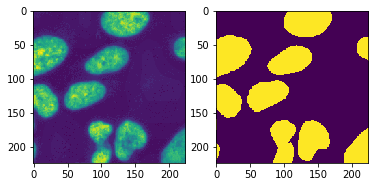

In [10]:
i,m =nucleus_dataset_train[0]
pilTrans = transforms.ToPILImage()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.asarray(pilTrans(i)))
axes[1].imshow(np.asarray(pilTrans(m)))

In [11]:
image, mask = iter(train_dl).next()
print(image.shape, mask.shape)

torch.Size([8, 1, 224, 224]) torch.Size([8, 1, 224, 224])


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
from torch.optim import lr_scheduler

use_gpu = torch.cuda.is_available()

#Loss
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)
    
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)        


def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_loss = 99999
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda(), volatile = True), Variable(labels.cuda(), volatile = True)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                outputs = F.sigmoid(outputs)
                
                loss = criterion(outputs.view(-1), labels.squeeze(1).view(-1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
# 
            if phase == 'valid' and valid_epoch_loss < best_loss:
                best_loss = valid_epoch_loss
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} valid loss: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, 
                valid_epoch_loss))
            
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [13]:
unet = UNet(1, depth=5, in_channels=1, merge_mode='concat', up_mode='transpose')

if use_gpu:
    unet = unet.cuda()

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':val_dl}

In [14]:
start_time = time.time()
model = train_model(dloaders, unet, criterion, optimizer, exp_lr_scheduler, num_epochs=40)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/39] train loss: 0.0384 valid loss: 0.0423
Epoch [1/39] train loss: 0.0315 valid loss: 0.0408
Epoch [2/39] train loss: 0.0502 valid loss: 0.0383
Epoch [3/39] train loss: 0.0512 valid loss: 0.0361
Epoch [4/39] train loss: 0.0282 valid loss: 0.0381
Epoch [5/39] train loss: 0.0273 valid loss: 0.0399
Epoch [6/39] train loss: 0.0273 valid loss: 0.0402
Epoch [7/39] train loss: 0.0256 valid loss: 0.0333
Epoch [8/39] train loss: 0.0252 valid loss: 0.0325
Epoch [9/39] train loss: 0.0254 valid loss: 0.0313
Epoch [10/39] train loss: 0.0248 valid loss: 0.0319
Epoch [11/39] train loss: 0.0237 valid loss: 0.0259
Epoch [12/39] train loss: 0.0193 valid loss: 0.0251
Epoch [13/39] train loss: 0.0151 valid loss: 0.0185
Epoch [14/39] train loss: 0.0140 valid loss: 0.0185
Epoch [15/39] train loss: 0.0133 valid loss: 0.0187
Epoch [16/39] train loss: 0.0127 valid loss: 0.0184
Epoch [17/39] train loss: 0.0128 valid loss: 0.0175
Epoch [18/39] train loss: 0.0121 valid loss: 0.0171
Epoch [19/39] train lo

In [17]:
#save model 
# torch.save(model.state_dict(), 'unet2.pth')

In [19]:
#load weight
load_weight = torch.load('unet2.pth')
unet.load_state_dict(load_weight)

In [14]:
itr = iter(train_dl)

In [15]:
imgs, masks = itr.next()
pred_mask = unet(Variable(imgs.cuda(),volatile = True))
pred_mask = F.sigmoid(pred_mask)
masks = Variable(masks.cuda(), volatile = True)

In [16]:
print('loss: ',criterion(pred_mask.view(-1), masks.view(-1)).data[0])

loss:  0.706304132938385


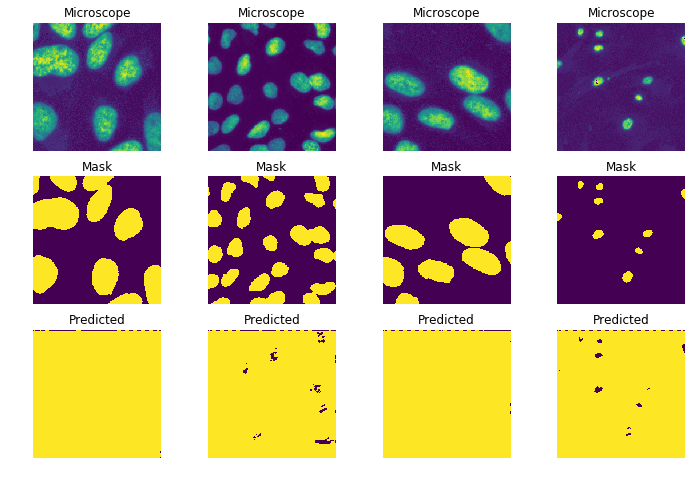

In [17]:
img_dict_list = []
n_img = 4
for i in range(n_img):
    img = np.asarray(pilTrans(imgs[i]))
    mask = masks[i][0].data.cpu().numpy()
    pred = (pred_mask[i][0].data.cpu() > 0.5).numpy()
    img_dict_list.append({'img':img, 'mask':mask,'pred':pred})

fig, m_axs = plt.subplots(3, n_img, figsize = (12, 8))
for c_row, (c_im, c_mask, c_pred) in zip(img_dict_list, m_axs.T):
    c_im.imshow(c_row['img'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_mask.imshow(c_row['mask'])
    c_mask.axis('off')
    c_mask.set_title('Mask')
    
    c_pred.imshow(c_row['pred'])
    c_pred.axis('off')
    c_pred.set_title('Predicted')

In [54]:
outputs = []
for i, data in enumerate(test_dl):
    img = data
    img = Variable(img.cuda(), volatile = True)
    
#     print(i, img.shape)
    output = unet(img)
    output = F.sigmoid(output)
    output_mask = output[0][0].data > 0.5
#     plt.imshow(output_mask)
    print(i, output_mask.shape)
    outputs.append(output_mask)
    
    

0 torch.Size([256, 256])
1 torch.Size([519, 253])
2 torch.Size([256, 256])
3 torch.Size([256, 256])
4 torch.Size([256, 256])
5 torch.Size([512, 680])
6 torch.Size([512, 640])
7 torch.Size([512, 680])
8 torch.Size([512, 640])
9 torch.Size([256, 256])
10 torch.Size([519, 162])
11 torch.Size([512, 640])
12 torch.Size([524, 348])
13 torch.Size([256, 256])
14 torch.Size([512, 680])
15 torch.Size([256, 256])
16 torch.Size([256, 256])
17 torch.Size([519, 253])
18 torch.Size([256, 256])
19 torch.Size([524, 348])
20 torch.Size([520, 348])
21 torch.Size([260, 347])
22 torch.Size([512, 680])
23 torch.Size([256, 256])
24 torch.Size([512, 680])
25 torch.Size([256, 256])
26 torch.Size([390, 239])
27 torch.Size([512, 640])
28 torch.Size([256, 256])
29 torch.Size([256, 256])
30 torch.Size([260, 347])
31 torch.Size([256, 256])
32 torch.Size([520, 348])
33 torch.Size([512, 640])
34 torch.Size([256, 256])
35 torch.Size([256, 256])
36 torch.Size([260, 347])
37 torch.Size([520, 348])
38 torch.Size([512, 64

In [56]:
outputs_numpy = [o.cpu().numpy() for o in outputs]

In [57]:
test_img_df['masks'] = pd.Series(outputs_numpy)
test_img_df.sample(3)

,ImageId,Stage,images,normalized_images,masks
43,9ab2d381f90b485a68b82bc07f94397a0373e3215ad209...,stage1,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...","[[6, 6, 6, 6, 6, 6, 19, 16, 9, 6, 3, 3, 9, 9, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
11,1cdbfee1951356e7b0a215073828695fe1ead5f8b1add1...,stage1,"[[[4, 4, 4], [0, 0, 0], [2, 2, 2], [2, 2, 2], ...","[[8, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
58,df40099c6306ca1f47fcc8a62e2fa39486d4e223177afd...,stage1,"[[[53, 53, 53], [45, 45, 45], [40, 40, 40], [3...","[[79, 66, 55, 46, 43, 43, 46, 41, 43, 43, 38, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


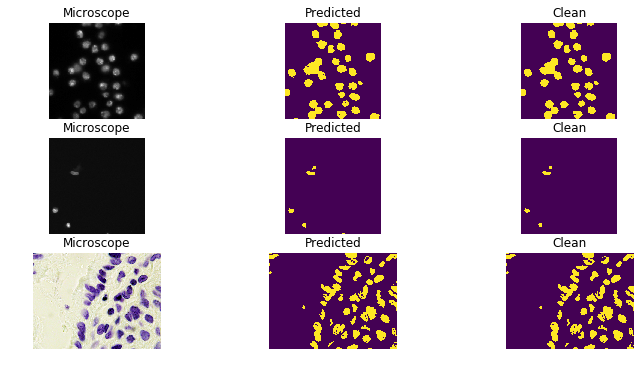

In [58]:
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

n_img = 3
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')
    

# Check RLE
Check that our approach for RLE encoding (stolen from [here](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)) works

In [59]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

# Calculate RLE for all the masks
Here we generate the RLE for all the masks and output the the results to a table. We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions, etc)

In [60]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [61]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

2945 regions found for 65 images


,EncodedPixels,ImageId
1162,101372 5 101882 7 102391 10 102901 12 103413 1...,472b1c5ff988dadc209faea92499bc07f305208dbda29d...
862,170904 7 171422 11 171940 14 172459 16 172977 ...,432f367a4c5b5674de2e2977744d10289a064e5704b21a...
496,323586 2 324097 5 324609 5 325121 6 325633 6 3...,259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67...


In [62]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('unet2_predictions.csv', index = False)